# Backtracking Logistic regression

This notebook is dedicated to numerical experiments for Logistic regression with $L^1$-regularization. The function to minimize is:

$$\min_{x\in\mathbb{R}^n} \frac{\lambda_1}{2\|A^Tb\|_\infty}\sum_{j=1}^m \log \left(1+e^{-b_ja_j^T x}\right)+\frac{\lambda_2}{2}\|x\|^2+\|x\|_1,$$
where $A\in \mathcal{M}_{m\times n}(\mathbb{R})$, $b\in\mathbb{R}^m$, $b_j\in\left\{-1,1\right\}$ and $a_j=\text{row}_j(A)$. This example was treated in "Adaptive restart of accelerated gradient methods under local quadratic growth condition" of Fercoq and Qu. 

Let us define $f:x\mapsto \frac{\lambda_1}{2\|A^Tb\|_\infty}\sum_{j=1}^m \log \left(1+e^{-b_ja_j^T x}\right)+\frac{\lambda_2}{2}\|x\|^2$ and $h:x\mapsto\|x\|_1$. We have that 
$$\nabla f(x)=-\frac{\lambda_1}{2\|A^Tb\|_\infty}\sum_{j=1}^m  \frac{b_ja_j}{1+e^{b_ja_j^T x}}+\lambda_2 x.$$
An upper bound for the Lipschitz constant of $\nabla f$ is $L=\frac{\lambda_1\|A^Tb\|^2}{8\|A^Tb\|_\infty}+\lambda_2$.

### Importing libraries, generating data and operators

In [1]:
#Importing libraries
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import scipy.linalg as spl
import time

In [2]:
#Importing additional packages: algorithms.py contains the algorithms to apply and visualizer.py is useful to plot loss functions.
import os.path
if not os.path.isfile('./visualizer.py'):
    !wget https://github.com/HippolyteLBRRR/Composite_optimization/raw/main/visualizer.py
if not os.path.isfile('./algorithms.py'):
    !wget https://github.com/HippolyteLBRRR/Composite_optimization/raw/main/algorithms.py
from algorithms import *
from visualizer import *

In [3]:
#Functions aiming to avoid overflow values inside exponential function (for example there is a problem computing
#log(1+exp(x)) for large values of x)

def log_exp(a,x):
    #returns (log(1+exp(-a^T x)))
    z=-np.dot(a,x)
    return np.maximum(z, 0) + np.log(np.exp(-np.absolute(z)) + 1)

def log_func(x):
    #returns (1/(1+e^x))
    return .5 * (1 + np.tanh(-.5 * x))

In [4]:
#Definition of the operators

def f_LR(x,A,b,ba,l1,l2):
    return l1*np.sum(log_exp(ba,x))+l2*npl.norm(x,2)**2/2
def Df_LR(x,A,b,ba,l1,l2):
    return l2*x-l1*np.sum(np.dot(ba.T,np.diag(log_func(np.dot(ba,x)))),axis=1)
def operators_LR(A,b,l1,l2):
    ba=np.dot(A.T,np.diag(b)).T
    L1=l1/(2*np.max(np.absolute(ba)))
    f = lambda x: f_LR(x,A,b,ba,L1,l2)
    h = lambda x: npl.norm(x,1)
    F = lambda x: f(x)+h(x)
    Df = lambda x: Df_LR(x,A,b,ba,L1,l2)
    proxh = lambda x,s:(x/(np.absolute(x)-1*(x==0)))*(np.absolute(x)-s)*(np.absolute(x)-s>0)
    return F,f,h,Df,proxh

In [5]:
# Random sampling of A and b and computation of the corresponding operators
n=10000
m=100
A=np.random.rand(m,n)
b=np.random.randint(0,2,m)*2-1
ba=np.dot(A.T,np.diag(b)).T
# Regularization parameters (same choices as Fercoq and Qu)
l1=1e0#1e2#1e1#
L_log=l1*npl.norm(A,2)**2/(8*np.max(np.absolute(ba)))
l2=L_log/(10*n)
L=L_log+l2 # Computation of the upper bound of the Lipschitz constant


x0=(np.random.uniform(-1,1,n))
exit_crit=lambda x,xm:npl.norm(x-xm,2) #critère d'arrêt -> norme du gradient composite
sp=lambda x,y:np.dot(x,y) #produit scalaire associé aux vecteurs
F,f,h,Df,proxh=operators_LR(A,b,l1,l2)

In [6]:
Niter=5000 # Maximum number of iterations (backtracking iterations are not taken in account)
epsilon=1e-8 # Expected accuracy on the composite gradient


### Applying first-order methods to this problem

In [7]:
# Documentation for the algorithms:
# help(FISTA)
# help(FISTA_automatic_restart)
# help(FISTA_BT)
# help(Free_FISTA)

In [8]:
# FISTA
xFISTA,costFISTA,ctimeFISTA=FISTA(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_FISTA=To_Plot(costFISTA,"FISTA",ctimeFISTA) # To_Plot object -> visualization

In [9]:
# FISTA restart by ADLR
xAR1,costAR1,ctimeAR1,irestartAR1=FISTA_automatic_restart(x0,1/L,Niter,epsilon,Df,proxh,F,exit_crit=exit_crit,track_ctime=True,track_restart=True)
Plot_AR1=To_Plot(costAR1,"ADLR restart",ctimeAR1,extra_points=irestartAR1)

/home/hlabarri/Documents/Thèse/Recherche/codes/benchmark_BT_restart/Benchmarking_Free_FISTA-main/algorithms.py:505: RuntimeWarning: divide by zero encountered in divide
  tab_mu = ((4/(s*(np.array(n_tab)[:-1]+1)**2)*


In [10]:
# FISTA with backtracking
L0=1 #initial estimation of the Lipschitz constant -> arbitrarily small value
rho=0.8
delta=0.95
xBT,costBT,ctimeBT,L_BT,ite_BT=FISTA_BT(x0, L0, rho, delta, Niter, epsilon, f, Df, proxh, h, exit_crit=exit_crit, sp=sp, out_L=True,out_ite=True, exit_norm=True,track_ctime=True)
Plot_BT1=To_Plot(costBT,"FISTA with backtracking, rho=%f, delta=%f, L0=%i"%(rho,delta,L0),ctimeBT)

In [11]:
# Free FISTA
L0=1
rho=0.8
delta=0.95
xBTR,costBTR1,ctimeBTR1,L_BTR1,ite_BTR1,irestartBTR1=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True, out_ite=True, exit_norm=True,track_ctime=True,track_restart=True)
Plot_BTR1=To_Plot(costBTR1,"Free-FISTA, rho=%f, delta=%f, L0=%i"%(rho,delta,L0),ctimeBTR1,extra_points=irestartBTR1)

In [12]:
# Computing an accurate approximation of the solution for visualization
xmin = Free_FISTA(xBTR, L_BTR1[-1], rho, delta, 3000, 1e-12, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=False, out_L=False, out_ite=False, exit_norm=True,track_ctime=False)

/home/hlabarri/Documents/Thèse/Recherche/codes/benchmark_BT_restart/Benchmarking_Free_FISTA-main/algorithms.py:975: RuntimeWarning: divide by zero encountered in divide
  ((obj_estimate[:-2]-obj_estimate[-1])/


Text(0, 0.5, '$\\log(F(x_k)-\\hat F)$')

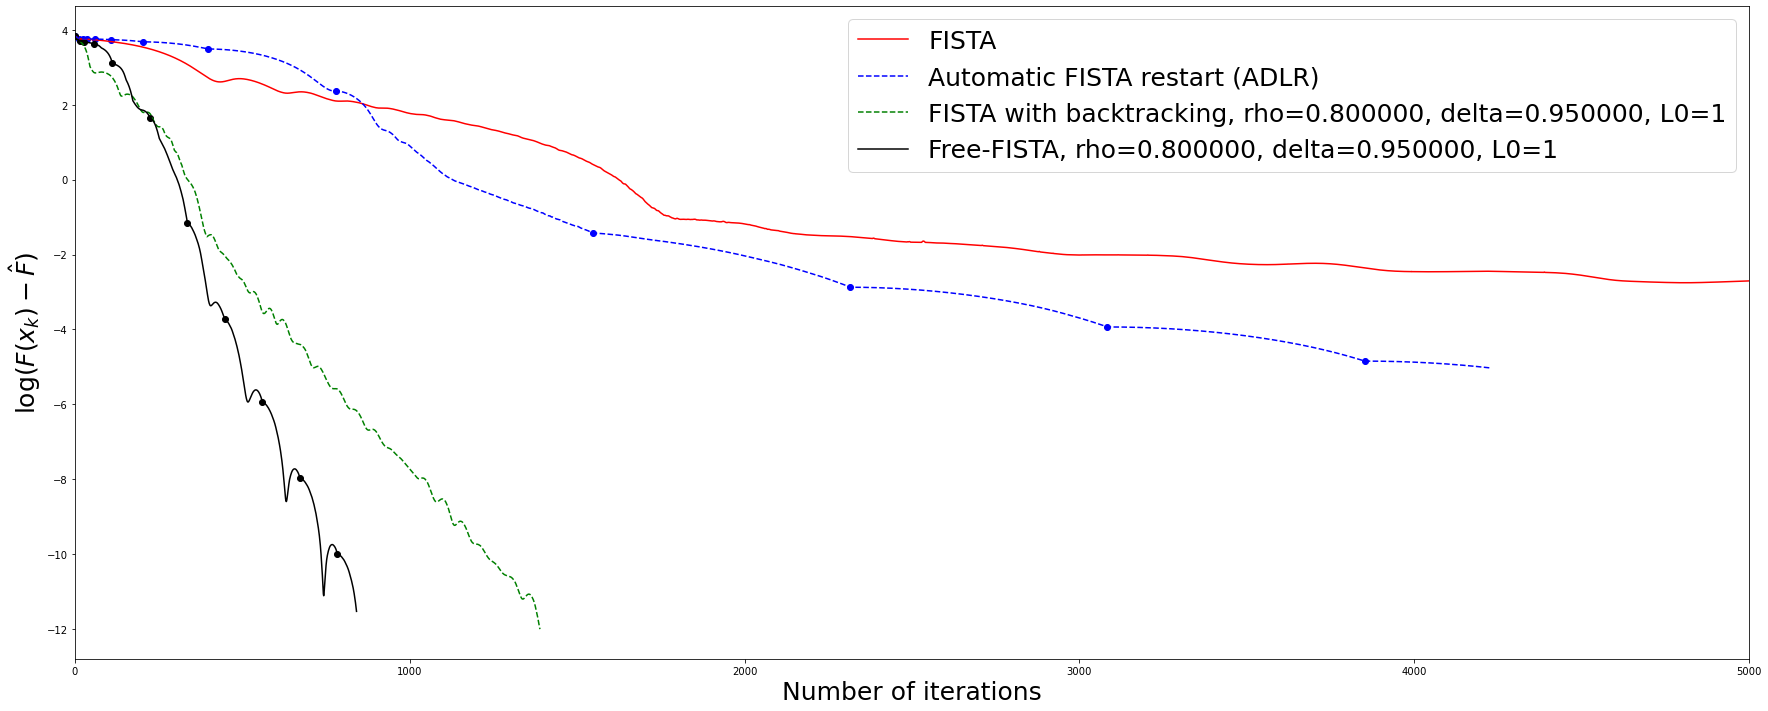

In [13]:
Plot([Plot_FISTA,Plot_AR1,Plot_BT1,Plot_BTR1],costmin=F(xmin),style=['-','--','--','-'],colorstyle=['r','b','g','k'],fontsize=25)
plt.xlabel("Number of iterations",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

Text(0, 0.5, '$\\log(F(x_k)-\\hat F)$')

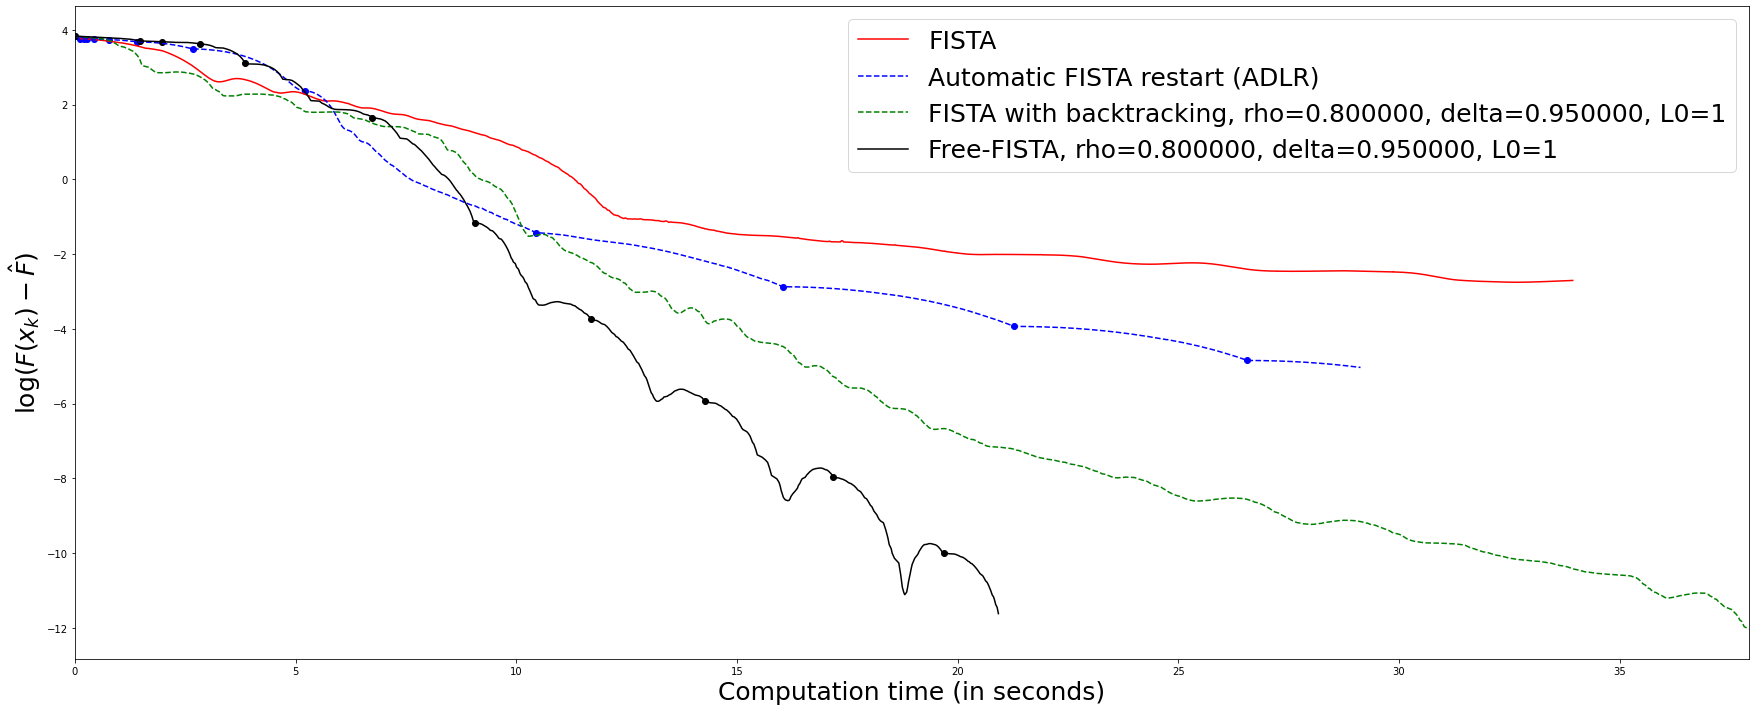

In [14]:
Plot([Plot_FISTA,Plot_AR1,Plot_BT1,Plot_BTR1],costmin=F(xmin),style=['-','--','--','-'],colorstyle=['r','b','g','k'],ite=False,fontsize=25)
plt.xlabel("Computation time (in seconds)",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

### Comparing different choices of parameters

In [ ]:
L0=L
rho=0.8
delta=0.95
xBTR,costBTR2,ctimeBTR2,L_BTR2,ite_BTR2,irestart_BTR2=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True, out_ite=True, exit_norm=True,track_ctime=True,track_restart=True)
Plot_BTR2=To_Plot(costBTR2,"Free-FISTA, rho=%f, delta=%f, L0=L (upper bound)"%(rho,delta),ctimeBTR2,extra_points=irestart_BTR2)

In [ ]:
L0=1
rho=0.8
delta=0.99
xBTR,costBTR3,ctimeBTR3,L_BTR3,ite_BTR3,irestart_BTR3=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True, out_ite=True, exit_norm=True,track_ctime=True,track_restart=True)
Plot_BTR3=To_Plot(costBTR3,"Free-FISTA, rho=%f, delta=%f, L0=%i"%(rho,delta,L0),ctimeBTR3,extra_points=irestart_BTR3)

In [ ]:
L0=L
rho=0.8
delta=0.99
xBTR,costBTR4,ctimeBTR4,L_BTR4,ite_BTR4,irestart_BTR4=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True, out_ite=True, exit_norm=True,track_ctime=True,track_restart=True)
Plot_BTR4=To_Plot(costBTR4,"Free-FISTA, rho=%f, delta=%f, L0=L (upper bound)"%(rho,delta),ctimeBTR4,extra_points=irestart_BTR4)

In [ ]:
Plot([Plot_BTR1,Plot_BTR2,Plot_BTR3,Plot_BTR4],costmin=F(xmin),style=['-','-.','--',':'],ite=False,fontsize=25)
plt.xlabel("Computation time (in seconds)",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

Comparing the theorical upper bound on $L$ and the values computed using backtracking

In [ ]:
plt.plot(L_BTR1,'-')
plt.plot(L_BTR2,'-.')
plt.plot(L_BTR3,'--')
plt.plot(L_BTR4,':')
plt.plot(np.zeros_like(L_BTR2)+L)
plt.legend([Plot_BTR1.legend,Plot_BTR2.legend,Plot_BTR3.legend,Plot_BTR4.legend,"Theoretical estimation"],prop={'size': 25})
plt.ylabel("Estimation of the Lipschitz constant",fontsize=25)
plt.xlabel("Number of iterations",fontsize=25)
plt.xlim([0,len(L_BTR2)])

In [ ]:
plt.bar(np.arange(0,len(ite_BTR1)),ite_BTR1)
plt.bar(np.arange(0,len(ite_BTR2)),ite_BTR2)
plt.legend([Plot_BTR1.legend,Plot_BTR2.legend],prop={'size': 25})
plt.xlabel("FISTA iterations",fontsize=25)
plt.ylabel("Number of backtracking iterations",fontsize=25)
plt.xlim([-10,len(ite_BTR2)])